In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.signal import argrelmin, argrelmax

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

import inspect

fontP = FontProperties()
fontP.set_size('small')

Using TensorFlow backend.


In [2]:
#Check Versions
print(tf.__version__)  #1.15.0
print(keras.__version__)  #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{(1-f(x_{T,i},\theta'))}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the first Gaussian Notebook.

We will now parametrize our network by giving it $\mu$ and $\sigma$ values in addition to $X_i\sim\mathcal{N}(\mu, \sigma)$.

First we uniformly sample $\mu$ and $\sigma$ values in some range

In [3]:
n_data_points = 10**7
mu_min = -2
mu_max = 2
mu_values = np.random.uniform(mu_min, mu_max, n_data_points)

sigma_min = 0.5
sigma_max = 4.5
sigma_values = np.random.uniform(sigma_min, sigma_max, n_data_points)

We then sample from normal distributions with these $\mu$ and $\sigma$ values.

In [4]:
X0 = [(np.random.normal(0, 1), mu_values[i], sigma_values[i])
      for i in range(n_data_points)]  # Note the zero in normal(0, 1)
X1 = [(np.random.normal(mu_values[i],
                        sigma_values[i]), mu_values[i], sigma_values[i])
      for i in range(n_data_points)]

Please note that the samples in X0 are not paired with $\mu=0, \sigma = 1$ as this would make the task trivial. 

Instead it is paired with the $\mu, \sigma$ values uniformly sampled in the specified range [$\mu_{min}, \mu_{max}$] and [$\sigma_{min}, \sigma_{max}$].

For every value of $\mu$ in mu_values and every value of $\sigma$ in sigma_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,\sigma)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ and $\sigma$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,\sigma)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

In [5]:
Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

## Build Model

In [6]:
inputs = Input((3, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs=inputs, outputs=outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

## Train DCTR model

In [7]:
earlystopping = EarlyStopping(patience=10, restore_best_weights=True)
dctr_model.fit(X_train,
               Y_train,
               epochs=200,
               batch_size=10000,
               validation_data=(X_test, Y_test),
               callbacks=[earlystopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8000000 samples, validate on 2000000 samples
Epoch 1/200





8000000/8000000 [==============================] - 13s 2us/step - loss: 0.5122 - val_loss: 0.5051
Epoch 2/200
8000000/8000000 [==============================] - 12s 1us/step - loss: 0.5050 - val_loss: 0.5049
Epoch 3/200
8000000/8000000 [==============================] - 12s 2us/step - loss: 0.5049 - val_loss: 0.5050
Epoch 4/200
8000000/8000000 [==============================] - 12s 2us/step - loss: 0.5049 - val_loss: 0.5051
Epoch 5/200
8000000/8000000 [==============================] - 12s 2us/step - loss: 0.5048 - val_loss: 0.5049
Epoch 6/200
8000000/8000000 [==============================] - 12s 2us/step - loss: 0.5048 - val_loss: 0.5051
Epoch 7/200
8000000/8000000 [==============================] - 12s 2us/step - loss: 0.5048 - val_loss: 0.5052
Epoch 8/200
8000000/8000000 [==============================] - 12s 2us/ste

# Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [8]:
theta0_param = (0, 1)


def reweight(d):  #from NN (DCTR)
    f = dctr_model(d)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights


# from analytical formula for normal distributions
def analytical_reweight(events,
                        mu1,
                        sigma1,
                        mu0=theta0_param[0],
                        sigma0=theta0_param[1]):
    weights = (sigma0 / sigma1) * K.exp(-0.5 * (((events - mu1) / sigma1)**2 -
                                                ((events - mu0) / sigma0)**2))
    #weights = K.expand_dims(weights, axis = 1)
    return weights

## Validate DCTR for any $\mu$ and $\sigma$

## Validate for Truth Level

In [9]:
mu1 = 1.5
sigma1 = 1.5
assert mu1 >= mu_min and mu1 <= mu_max  # choose mu1 in valid range
assert sigma1 >= sigma_min and sigma1 <= sigma_max  # choose mu1 in valid range
X0_val_T = np.random.normal(0, 1, n_data_points)
X1_val_T = np.random.normal(mu1, sigma1, n_data_points)

In [10]:
X_input = np.array([(x, mu1, sigma1) for x in X0_val_T])

In [11]:
weights = reweight(tf.convert_to_tensor(X_input, dtype=tf.float32))
analytical_weights = analytical_reweight(X0_val_T, mu1, sigma1)
weights = K.eval(weights)
analytical_weights = K.eval(analytical_weights)

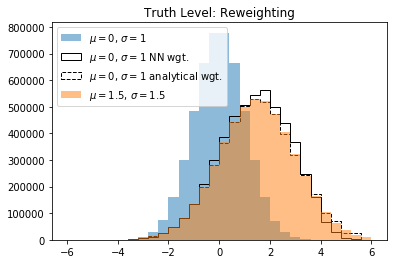

In [12]:
bins = np.linspace(-6, 6, 31)
plt.hist(X0_val_T, bins=bins, alpha=0.5, label=r'$\mu=0$, $\sigma=1$')
plt.hist(X0_val_T,
         bins=bins,
         label=r'$\mu=0$, $\sigma=1$ NN wgt.',
         weights=weights,
         histtype='step',
         color='k')
plt.hist(X0_val_T,
         bins=bins,
         label=r'$\mu=0$, $\sigma=1$ analytical wgt.',
         weights=analytical_weights,
         histtype='step',
         linestyle='--',
         color='k')
plt.hist(X1_val_T,
         bins=bins,
         alpha=0.5,
         label=r'$\mu={}$, $\sigma={}$'.format(mu1, sigma1))
plt.legend()
plt.title("Truth Level: Reweighting")
plt.show()

## Validate for Detector Level

In [13]:
# Generate detector level by smearing truth

epsilon_val =0.5  #Smearing width

X0_val_D = np.array([(x + np.random.normal(0, epsilon_val)) for x in X0_val_T]) #Detector smearing
X1_val_D = np.array([(x + np.random.normal(0, epsilon_val)) for x in X1_val_T]) #Detector smearing

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


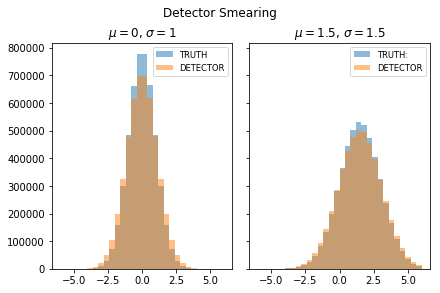

In [14]:
fig, axs = plt.subplots(1, 2, sharey= True,  constrained_layout=True)
fig.suptitle('Detector Smearing')
axs[0].set_title('$\mu=0$, $\sigma=1$')
axs[0].hist(X0_val_T, bins = bins, alpha = 0.5, label = 'TRUTH')
axs[0].hist(X0_val_D, bins = bins, alpha = 0.5, label = 'DETECTOR')
axs[0].legend(prop = fontP)
axs[1].set_title('$\mu={}$, $\sigma={}$'.format(mu1, sigma1))
axs[1].hist(X1_val_T, bins = bins, alpha = 0.5, label = 'TRUTH:')
axs[1].hist(X1_val_D, bins = bins, alpha = 0.5, label = 'DETECTOR')
axs[1].legend(prop = fontP)
fig.show()

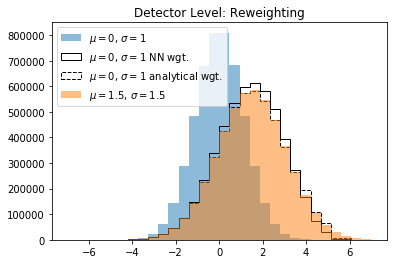

In [15]:
bins = np.linspace(-7,7,31)
plt.hist(X0_val_D, bins = bins, alpha = 0.5, label = r'$\mu=0$, $\sigma=1$')
plt.hist(X0_val_D, bins = bins, label = r'$\mu=0$, $\sigma=1$ NN wgt.',
         weights=weights, histtype='step', color='k')
plt.hist(X0_val_D, bins = bins, label = r'$\mu=0$, $\sigma=1$ analytical wgt.',
         weights=analytical_weights, histtype='step', linestyle = '--',color='k')
plt.hist(X1_val_D, bins = bins, alpha = 0.5, label = r'$\mu={}$, $\sigma={}$'.format(mu1, sigma1))
plt.legend()
plt.title("Detector Level: Reweighting")
#plt.savefig("Detector Level: Reweighting.png")
plt.show()

# Saving Model

In [16]:
'''
model_json = dctr_model.to_json()
with open("2d_gaussian_dctr_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dctr_model.save_weights("2d_gaussian_dctr_model.h5")
print("Saved model to disk")
'''

'\nmodel_json = dctr_model.to_json()\nwith open("2d_gaussian_dctr_model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\ndctr_model.save_weights("2d_gaussian_dctr_model.h5")\nprint("Saved model to disk")\n'

# Alternative Fit

## Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

To apply detector effects, each event $x_{T,i}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}(0,\epsilon)$,where $\epsilon$ represents the smearing. Thus: $x_{D,i} = x_{T,i} + Z_{i}$

In [17]:
N = 10**6
#param = (mu, sigma)
theta0_param = (0,1) #this is the simulation ... N.B. this notation is reversed from above!
theta1_param = (1,1.5) #this is the data (the target)

epsilon =theta0_param[1]/2 #Smearing width

theta0_T = np.random.normal(theta0_param[0],theta0_param[1],N)
theta0_D = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_T]) #Detector smearing
theta0 = np.stack([theta0_T, theta0_D], axis = 1)

theta1_T = np.random.normal(theta1_param[0],theta1_param[1],N)
theta1_D = np.array([(x + np.random.normal(0, epsilon)) for x in theta1_T]) #Detector smearing
theta1 = np.stack([theta1_T, theta0_D], axis = 1)

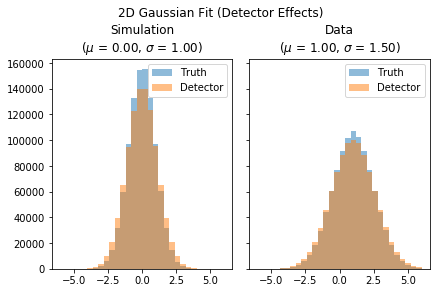

In [18]:
bins = np.linspace(-6,6,31)

fig, axs = plt.subplots(1, 2, sharey= True,  constrained_layout=True)
fig.suptitle('2D Gaussian Fit (Detector Effects)')

axs[0].set_title("Simulation\n($\mu$ = {:.2f}, $\sigma$ = {:.2f})".format(theta0_param[0], theta0_param[1]))
axs[0].hist(theta0_T, bins = bins, alpha = 0.5, label = 'Truth')
axs[0].hist(theta0_D, bins = bins, alpha = 0.5, label = 'Detector')
axs[0].legend()

axs[1].set_title("Data\n($\mu$ = {:.2f}, $\sigma$ = {:.2f})".format(theta1_param[0], theta1_param[1]))
axs[1].hist(theta1_T, bins = bins, alpha = 0.5, label = 'Truth')
axs[1].hist(theta1_D, bins = bins, alpha = 0.5, label = 'Detector')
axs[1].legend()

#fig.savefig("2D Gaussian: Data ($\mu$ = {:.2f}, $\sigma$ = {:.2f}) w detector effects.png".format(theta1_param[0], theta1_param[1]))
fig.show()

In [19]:
#'Erasing' Truth level for data, we can't actually observe this
theta1 = np.stack([np.zeros_like(theta0_D), theta0_D], axis = 1)

In [20]:
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0_D,theta1_D])
y_true = np.concatenate([labels0,labels1]) 
# 'hiding' truth level for simulation in model output (used in reweighting)
truth_level = np.concatenate([theta0_T, theta1_T])
yvals = np.stack([y_true, truth_level], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(xvals, yvals, test_size=0.5)
X_train_theta, X_test_theta, y_train_theta, y_test_theta = train_test_split(xvals, yvals, test_size=0.)

## Fitting Model

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

### Loading Model

In [21]:
# load json and create model
'''
json_file = open('2d_gaussian_dctr_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dctr_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
dctr_model.load_weights("2d_gaussian_dctr_model.h5")
print("Loaded model from disk")
'''


'\njson_file = open(\'2d_gaussian_dctr_model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\ndctr_model = keras.models.model_from_json(loaded_model_json)\n# load weights into new model\ndctr_model.load_weights("2d_gaussian_dctr_model.h5")\nprint("Loaded model from disk")\n'

In [22]:
# Change to True for analytical_reweight

reweight_analytically = False

### Cross Section for $\mu$

In [23]:
myinputs = Input(shape=(1,), dtype = tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 1000

earlystopping = EarlyStopping(patience = 3, 
                              min_delta = 0.00005,
                              restore_best_weights=True)

def my_loss_wrapper(val=0):
    
    def my_loss(y_true,y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size)) 
        y_labels = tf.gather(y_true, [0], axis = 1) #actual y_true for loss
        x_T = tf.gather(y_true, [1], axis = 1) # sim truth for reweighting

        theta_prime = [val, theta1_param[1]] #fixed theta_sigma = sigma_truth
    
        #creating tensor with same length as inputs, with theta_prime in every entry
        concat_input_and_params = K.ones(shape = (x_T.shape[0], 2))*theta_prime
        #combining and reshaping into correct format:
        data = K.concatenate((x_T, concat_input_and_params), axis=-1)
        
        if reweight_analytically == False: #NN reweight
            w = reweight(data)
        else: # analytical reweight
            w = analytical_reweight(events = x_T, 
                                    mu1 = theta_prime[0], 
                                    sigma1 = theta_prime[1]) 
        
        # Mean Squared Loss
        t_loss = y_labels*(y_labels - y_pred)**2+(w)*(1.-y_labels)*(y_labels - y_pred)**2
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        """
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_labels)*K.log(y_pred) +w*(1-y_labels)*K.log(1-y_pred))
        """
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [24]:
thetas = np.linspace(-2,2,17)
lvals = []
vlvals = []
 
for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam', loss=my_loss_wrapper(theta),metrics=['accuracy'])
    model.fit(np.array(X_train), y_train, 
              epochs=100, batch_size=1000,
              validation_data=(np.array(X_test), y_test),
              verbose=1, callbacks = [earlystopping])
    lvals+=[np.min(model.history.history['loss'])]
    vlvals+=[np.min(model.history.history['val_loss'])]
    print(lvals)
    print
    pass
print(lvals)

testing theta = : -2.0
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.1202 - acc: 0.2905 - val_loss: 0.1195 - val_acc: 0.2895
Epoch 2/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.1191 - acc: 0.2896 - val_loss: 0.1196 - val_acc: 0.2917
Epoch 3/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.1191 - acc: 0.2896 - val_loss: 0.1195 - val_acc: 0.2889
Epoch 4/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.1191 - acc: 0.2897 - val_loss: 0.1196 - val_acc: 0.2911
[0.119138102799654]
testing theta = : -1.75
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.1316 - acc: 0.2941 - val_loss: 0.1319 - val_acc: 0.2917
Epoch 2/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.1316 - acc: 0.2942 - val_loss: 0.13

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2448 - acc: 0.3286 - val_loss: 0.2443 - val_acc: 0.3283
Epoch 2/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.2447 - acc: 0.3280 - val_loss: 0.2446 - val_acc: 0.3278
Epoch 3/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.2447 - acc: 0.3275 - val_loss: 0.2446 - val_acc: 0.3283
Epoch 4/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.2447 - acc: 0.3275 - val_loss: 0.2444 - val_acc: 0.3274
[0.119138102799654, 0.1315559401512146, 0.14397506241500377, 0.15869527372717857, 0.17390087382495403, 0.1877908307760954, 0.2010701435059309, 0.21394480450451375, 0.2261292113661766, 0.23633398194611072, 0.24467911495268344]
testing theta = : 0.75
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2504 - acc: 0.3237 - val_loss: 0.2499 - val_acc: 0.3274
Epoc

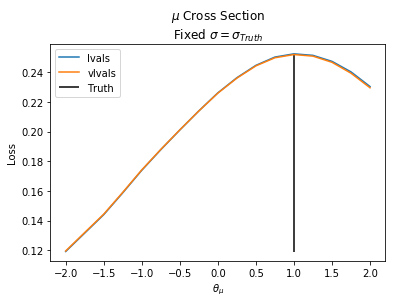

In [26]:
plt.plot(thetas,lvals, label = 'lvals')
plt.plot(thetas, vlvals, label = 'vlvals')
plt.title("$\mu$ Cross Section\nFixed $\sigma = \sigma_{Truth}$")
plt.xlabel(r'$\theta_{\mu}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[0], ymin = np.min(lvals), ymax = np.max(lvals), label = 'Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-DetectorEffects-\mu cross section.png")
plt.show()

### Cross Section for $\sigma$

In [27]:
myinputs = Input(shape=(1,), dtype = tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 1000

earlystopping = EarlyStopping(patience = 3, 
                              min_delta = 0.00005,
                              restore_best_weights=True)

def my_loss_wrapper(val=0):
    
    def my_loss(y_true,y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size)) 
        y_labels = tf.gather(y_true, [0], axis = 1) #actual y_true for loss
        x_T = tf.gather(y_true, [1], axis = 1) # sim truth for reweighting

        theta_prime = [theta1_param[0], val] #fixed theta_mu = mu_truth
    
        #creating tensor with same length as inputs, with theta_prime in every entry
        concat_input_and_params = K.ones(shape = (x_T.shape[0], 2))*theta_prime
        #combining and reshaping into correct format:
        data = K.concatenate((x_T, concat_input_and_params), axis=-1)
        
        if reweight_analytically == False: #NN reweight
            w = reweight(data)
        else: # analytical reweight
            w = analytical_reweight(events = x_T, 
                                    mu1 = theta_prime[0], 
                                    sigma1 = theta_prime[1]) 
        
        # Mean Squared Loss
        t_loss = y_labels*(y_labels - y_pred)**2+(w)*(1.-y_labels)*(y_labels - y_pred)**2
        
        # Categorical Cross-Entropy Loss
        '''
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_labels)*K.log(y_pred) +w*(1-y_labels)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [28]:
thetas = np.linspace(0.5,4.5,17)
lvals = []
vlvals = []


for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam', loss=my_loss_wrapper(theta),metrics=['accuracy'])
    model.fit(np.array(X_train), y_train, epochs=100, batch_size=batch_size,validation_data=(np.array(X_test), y_test),verbose=1,callbacks = [earlystopping])
    lvals+=[np.min(model.history.history['loss'])]
    vlvals+=[np.min(model.history.history['val_loss'])]
    print
    pass
print(lvals)

testing theta = : 0.5
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2000 - acc: 0.2486 - val_loss: 0.1981 - val_acc: 0.2466
Epoch 2/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.1984 - acc: 0.2466 - val_loss: 0.1980 - val_acc: 0.2449
Epoch 3/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.1984 - acc: 0.2463 - val_loss: 0.1981 - val_acc: 0.2458
Epoch 4/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.1983 - acc: 0.2470 - val_loss: 0.1981 - val_acc: 0.2479
Epoch 5/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.1983 - acc: 0.2464 - val_loss: 0.1981 - val_acc: 0.2456
testing theta = : 0.75
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2235 - acc: 0.2467 - val_loss: 0.2231 - val_acc: 0.2496
E

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2117 - acc: 0.2504 - val_loss: 0.2106 - val_acc: 0.2432
Epoch 2/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.2111 - acc: 0.2480 - val_loss: 0.2102 - val_acc: 0.2465
Epoch 3/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.2109 - acc: 0.2480 - val_loss: 0.2101 - val_acc: 0.2475
Epoch 4/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.2109 - acc: 0.2491 - val_loss: 0.2103 - val_acc: 0.2429
Epoch 5/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.2107 - acc: 0.2483 - val_loss: 0.2113 - val_acc: 0.2650
Epoch 6/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.2108 - acc: 0.2515 - val_loss: 0.2102 - val_acc: 0.2513
testing theta = : 3.25
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2043

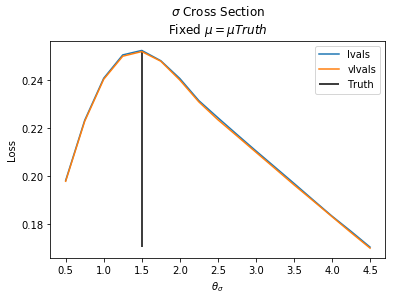

In [29]:
plt.plot(thetas,lvals, label = 'lvals')
plt.plot(thetas, vlvals, label = 'vlvals')
plt.title("$\sigma$ Cross Section\nFixed $\mu = \mu{Truth}$")
plt.xlabel(r'$\theta_{\sigma}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[1], ymin = np.min(lvals), ymax = np.max(lvals), label = 'Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-DetectorEffects-\sigma cross section.png")
plt.show()

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

### Building and Training Fitting Model

In [30]:
print_weights = LambdaCallback(on_epoch_end=lambda batch,
                               logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = [0., 1.]

fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(patience = 5,
                              restore_best_weights=True)

In [31]:
myinputs_fit = Input(shape=(1,))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=(2,),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False
index_refine = np.array([0])
batch_size = 2*N
lr_initial = 5e-1 #smaller learning rate yields better precision
iterations = 75 #but requires more epochs to train
optimizer = keras.optimizers.Adam(lr=lr_initial)

def my_loss_wrapper_fit(mysign = 1):
    theta = 0. #starting value
    #Getting theta_prime:
    
    def my_loss(y_true,y_pred):
        #Getting theta_prime:
        if train_theta == False:
            theta_prime = model_fit.layers[-1].get_weights()[0] #when not training theta, fetch as np array
            y_true = tf.gather(y_true, np.arange(1000)) 
        else:
            theta_prime = model_fit.trainable_weights[-1] #when trainingn theta, fetch as tf.Variable
            y_true = tf.gather(y_true, np.arange(batch_size)) 
        y_labels = tf.gather(y_true, [0], axis = 1) #actual y_true for loss
        x_T = tf.gather(y_true, [1], axis = 1) # sim truth for reweighting
        
        #creating tensor with same length as inputs, with theta_prime in every entry
        concat_input_and_params = K.ones(shape = (x_T.shape[0], 2), dtype=tf.float32)*theta_prime
        data = K.concatenate((x_T, concat_input_and_params), axis=-1)
        if reweight_analytically == False: #NN reweight
            w = reweight(data)
        else: # analytical reweight
            w = analytical_reweight(events = x_T, 
                                    mu1 = theta_prime[0], 
                                    sigma1 = theta_prime[1]) 
        
        # Mean Squared Loss
        t_loss = mysign*(y_labels*(y_labels - y_pred)**2+(w)*(1.-y_labels)*(y_labels - y_pred)**2)
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        """
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_labels)*K.log(y_pred) +w*(1-y_labels)*K.log(1-y_pred))
        """
        
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 2         
Total params: 16,899
Trainable params: 16,899
Non-trainable params: 0
_________________________________________________________________


In [32]:
for iteration in range(iterations):    
    print("Iteration: ", iteration )
    for i in range(len(model_fit.layers)-1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass
    
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss=my_loss_wrapper_fit(1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train), y_train, epochs=20, batch_size=1000,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer=optimizer, loss=my_loss_wrapper_fit(-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta), y_train_theta, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test_theta), y_test_theta),verbose=1,callbacks=callbacks)
    
    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10
    
    fit_vals_mu = np.array(fit_vals)[(index_refine[-1]):,0]
    fit_vals_sigma = np.array(fit_vals)[(index_refine[-1]):,1]
    
    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
    extrema_mu = np.concatenate((argrelmin(fit_vals_mu)[0], argrelmax(fit_vals_mu)[0]))
    extrema_mu = extrema_mu[extrema_mu>= iteration - index_refine[-1] -20]
            
    extrema_sigma = np.concatenate((argrelmin(fit_vals_sigma)[0], argrelmax(fit_vals_sigma)[0]))
    extrema_sigma = extrema_sigma[extrema_sigma >= iteration - index_refine[-1] - 20]
    '''
    print("index_refine", index_refine)
    print("extrema_mu", extrema_mu)
    print("extrema_sigma", extrema_sigma)
    '''
    
    if (len(extrema_mu) == 0) or (len(extrema_sigma) == 0): # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema_mu) >= 6) and (len(extrema_sigma) >= 6): #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print("Refining learning rate")
        optimizer.lr = optimizer.lr/10
        
        mean_fit = np.array([[np.mean(fit_vals_mu[len(fit_vals_mu)-4:len(fit_vals_mu)]),
                              np.mean(fit_vals_sigma[len(fit_vals_sigma)-4:len(fit_vals_sigma)])]])

        model_fit.layers[-1].set_weights(mean_fit)
    pass
    pass
    

Iteration:  0
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2145 - acc: 0.3226 - val_loss: 0.2101 - val_acc: 0.3287
Epoch 2/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2098 - acc: 0.3292 - val_loss: 0.2099 - val_acc: 0.3290
Epoch 3/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2096 - acc: 0.3294 - val_loss: 0.2099 - val_acc: 0.3290
Epoch 4/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2096 - acc: 0.3295 - val_loss: 0.2098 - val_acc: 0.3291
Epoch 5/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2096 - acc: 0.3294 - val_loss: 0.2098 - val_acc: 0.3291
Epoch 6/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2096 - acc: 0.3295 - val_loss: 0.2098 - val_acc: 0.3290
Epoch 7/20
1000000/1000000 [==============================] - 7s 7us/step - loss:

Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 5s 3us/step - loss: -0.2501 - acc: 0.2696
. theta fit =  [1.1734337 1.5346389]
Iteration:  5
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.1887 - val_loss: 0.2515 - val_acc: 0.1806
Epoch 2/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2521 - acc: 0.1804 - val_loss: 0.2517 - val_acc: 0.1864
Epoch 3/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2521 - acc: 0.1808 - val_loss: 0.2518 - val_acc: 0.1787
Epoch 4/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2521 - acc: 0.1797 - val_loss: 0.2517 - val_acc: 0.1870
Epoch 5/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2520 - acc: 0.1802 - val_loss: 0.2515 - val_acc: 0.1762
Epoch 6/20
1000000

2000000/2000000 [==============================] - 6s 3us/step - loss: -0.2520 - acc: 0.2212
. theta fit =  [1.0437809 1.4491282]
Iteration:  11
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2524 - acc: 0.2083 - val_loss: 0.2520 - val_acc: 0.1899
Epoch 2/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2525 - acc: 0.2091 - val_loss: 0.2520 - val_acc: 0.1950
Epoch 3/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2524 - acc: 0.2112 - val_loss: 0.2522 - val_acc: 0.1941
Epoch 4/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2524 - acc: 0.2100 - val_loss: 0.2520 - val_acc: 0.1887
Epoch 5/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2524 - acc: 0.2104 - val_loss: 0.2520 - val_acc: 0.1877
Epoch 6/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2523

Epoch 20/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2523 - acc: 0.1831 - val_loss: 0.2521 - val_acc: 0.1765
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 6s 3us/step - loss: -0.2523 - acc: 0.1763
. theta fit =  [1.067681  1.4728613]
Iteration:  16
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2524 - acc: 0.1862 - val_loss: 0.2521 - val_acc: 0.1898
Epoch 2/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2524 - acc: 0.1922 - val_loss: 0.2521 - val_acc: 0.1835
Epoch 3/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2523 - acc: 0.1904 - val_loss: 0.2523 - val_acc: 0.2046
Epoch 4/20
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2524 - acc: 0.1911 - val_loss: 0.2522 - val_acc: 0.1924
Epoch 5/20
100

Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2524 - acc: 0.1909 - val_loss: 0.2521 - val_acc: 0.1862
Epoch 2/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1871 - val_loss: 0.2523 - val_acc: 0.1963
Epoch 3/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1924 - val_loss: 0.2520 - val_acc: 0.1883
Epoch 4/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1892 - val_loss: 0.2522 - val_acc: 0.2314
Epoch 5/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1911 - val_loss: 0.2521 - val_acc: 0.1870
Epoch 6/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1872 - val_loss: 0.2521 - val_acc: 0.1948
Epoch 7/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - ac

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1989 - val_loss: 0.2521 - val_acc: 0.1867
Epoch 6/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1984 - val_loss: 0.2521 - val_acc: 0.1830
Epoch 7/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1974 - val_loss: 0.2521 - val_acc: 0.1840
Epoch 8/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1971 - val_loss: 0.2521 - val_acc: 0.1794
Epoch 9/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1941 - val_loss: 0.2522 - val_acc: 0.1826
Epoch 10/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.2058 - val_loss: 0.2522 - val_acc: 0.1890
Epoch 11/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1930 - val_loss: 0.2521 - val_acc: 0.2182
Epoch 12/20
1000000/1000000 [

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1948 - val_loss: 0.2521 - val_acc: 0.1840
Epoch 16/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1963 - val_loss: 0.2521 - val_acc: 0.1840
Epoch 17/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1938 - val_loss: 0.2521 - val_acc: 0.1885
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 8s 4us/step - loss: -0.2522 - acc: 0.1821
. theta fit =  [1.045541  1.4827291]
Iteration:  30
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 13s 13us/step - loss: 0.2524 - acc: 0.1954 - val_loss: 0.2521 - val_acc: 0.1841
Epoch 2/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1951 - val_loss: 0.2521 - val_acc: 0.1822
Epoch 3/20
1000000/10000

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.2021 - val_loss: 0.2522 - val_acc: 0.1941
Epoch 4/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1899 - val_loss: 0.2521 - val_acc: 0.1981
Epoch 5/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1982 - val_loss: 0.2521 - val_acc: 0.2327
Epoch 6/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1978 - val_loss: 0.2522 - val_acc: 0.1916
Epoch 7/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1902 - val_loss: 0.2521 - val_acc: 0.1898
Epoch 8/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1999 - val_loss: 0.2521 - val_acc: 0.2317
Epoch 9/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1932 - val_loss: 0.2521 - val_acc: 0.1928
Epoch 10/20
1000000/1000000 [==

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1944 - val_loss: 0.2521 - val_acc: 0.1829
Epoch 11/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1888 - val_loss: 0.2521 - val_acc: 0.1812
Epoch 12/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1909 - val_loss: 0.2521 - val_acc: 0.2471
Epoch 13/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.2002 - val_loss: 0.2521 - val_acc: 0.1922
Epoch 14/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1941 - val_loss: 0.2521 - val_acc: 0.1938
Epoch 15/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.2052 - val_loss: 0.2521 - val_acc: 0.1842
Epoch 16/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1907 - val_loss: 0.2521 - val_acc: 0.1834
Epoch 17/20
1000000/10000

Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 16s 16us/step - loss: 0.2523 - acc: 0.2024 - val_loss: 0.2521 - val_acc: 0.1848
Epoch 2/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1919 - val_loss: 0.2521 - val_acc: 0.1863
Epoch 3/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1941 - val_loss: 0.2521 - val_acc: 0.1814
Epoch 4/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1979 - val_loss: 0.2521 - val_acc: 0.1821
Epoch 5/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1943 - val_loss: 0.2521 - val_acc: 0.2445
Epoch 6/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1963 - val_loss: 0.2521 - val_acc: 0.2310
Epoch 7/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - ac

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1907 - val_loss: 0.2521 - val_acc: 0.2315
Epoch 3/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1955 - val_loss: 0.2521 - val_acc: 0.2121
Epoch 4/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.2004 - val_loss: 0.2521 - val_acc: 0.1871
Epoch 5/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1959 - val_loss: 0.2521 - val_acc: 0.2224
Epoch 6/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1988 - val_loss: 0.2521 - val_acc: 0.1822
Epoch 7/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.2026 - val_loss: 0.2521 - val_acc: 0.1873
Epoch 8/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1950 - val_loss: 0.2521 - val_acc: 0.2161
Epoch 9/20
1000000/1000000 [===

2000000/2000000 [==============================] - 12s 6us/step - loss: -0.2522 - acc: 0.1818
. theta fit =  [1.0450557 1.4818332]
Iteration:  51
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 17s 17us/step - loss: 0.2523 - acc: 0.1900 - val_loss: 0.2521 - val_acc: 0.1853
Epoch 2/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1930 - val_loss: 0.2521 - val_acc: 0.1952
Epoch 3/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1914 - val_loss: 0.2522 - val_acc: 0.1901
Epoch 4/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.2002 - val_loss: 0.2521 - val_acc: 0.1870
Epoch 5/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1929 - val_loss: 0.2521 - val_acc: 0.1846
Epoch 6/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.252

1000000/1000000 [==============================] - 18s 18us/step - loss: 0.2523 - acc: 0.1973 - val_loss: 0.2521 - val_acc: 0.1837
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.1924 - val_loss: 0.2521 - val_acc: 0.2184
Epoch 3/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1950 - val_loss: 0.2521 - val_acc: 0.1944
Epoch 4/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.1989 - val_loss: 0.2521 - val_acc: 0.1945
Epoch 5/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1961 - val_loss: 0.2521 - val_acc: 0.1876
Epoch 6/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2523 - acc: 0.1936 - val_loss: 0.2521 - val_acc: 0.2023
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 12s 6us/step - loss: -0.2522 - acc: 0.1835
. 

Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 19s 19us/step - loss: 0.2523 - acc: 0.1920 - val_loss: 0.2521 - val_acc: 0.1869
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.1968 - val_loss: 0.2521 - val_acc: 0.1871
Epoch 3/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.2029 - val_loss: 0.2521 - val_acc: 0.1853
Epoch 4/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.1943 - val_loss: 0.2521 - val_acc: 0.2300
Epoch 5/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2524 - acc: 0.1936 - val_loss: 0.2521 - val_acc: 0.2261
Epoch 6/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.2000 - val_loss: 0.2521 - val_acc: 0.1914
Epoch 7/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - ac

Epoch 15/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.1992 - val_loss: 0.2521 - val_acc: 0.1941
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 13s 7us/step - loss: -0.2522 - acc: 0.1842
. theta fit =  [1.0446835 1.4816767]
Iteration:  65
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 19s 19us/step - loss: 0.2523 - acc: 0.1991 - val_loss: 0.2521 - val_acc: 0.2255
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.2018 - val_loss: 0.2521 - val_acc: 0.1858
Epoch 3/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.2000 - val_loss: 0.2521 - val_acc: 0.1860
Epoch 4/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.1987 - val_loss: 0.2521 - val_acc: 0.1833
Epoch 5/20
10

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.1952 - val_loss: 0.2521 - val_acc: 0.1850
Epoch 13/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2522 - acc: 0.1940 - val_loss: 0.2522 - val_acc: 0.1892
Epoch 14/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.2014 - val_loss: 0.2521 - val_acc: 0.1833
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 13s 6us/step - loss: -0.2522 - acc: 0.1848
. theta fit =  [1.0446988 1.4816922]
Iteration:  70
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 20s 20us/step - loss: 0.2523 - acc: 0.2109 - val_loss: 0.2521 - val_acc: 0.2234
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.1937 - val_loss: 0.2521 - val_acc: 0.1884
Epoch 3/20
1000000/1000

2000000/2000000 [==============================] - 13s 6us/step - loss: -0.2522 - acc: 0.1891
. theta fit =  [1.0446985 1.4817008]
Iteration:  74
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 20s 20us/step - loss: 0.2525 - acc: 0.1913 - val_loss: 0.2521 - val_acc: 0.1885
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2524 - acc: 0.1922 - val_loss: 0.2521 - val_acc: 0.1907
Epoch 3/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.1942 - val_loss: 0.2521 - val_acc: 0.2259
Epoch 4/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.1987 - val_loss: 0.2521 - val_acc: 0.1826
Epoch 5/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2523 - acc: 0.1912 - val_loss: 0.2521 - val_acc: 0.1878
Epoch 6/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.252

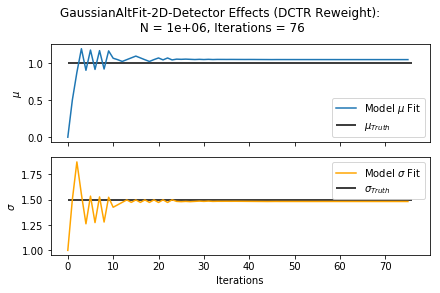

In [33]:
fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex= True,  constrained_layout=True)
fig.suptitle("GaussianAltFit-2D-Detector Effects (DCTR Reweight):\n N = {:.0e}, Iterations = {:.0f}".format(N, len(fit_vals)))
axs[0].plot(fit_vals[:,0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], 0, len(fit_vals), label = '$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(fit_vals[:,1], label='Model $\sigma$ Fit', color ='orange')
axs[1].hlines(theta1_param[1], 0, len(fit_vals), label = '$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
plt.savefig("GaussianAltFit-2D-Detector Effects (DCTR Reweight):\n N = {:.0e}, Iterations = {:.0f}.png".format(N, len(fit_vals)))
plt.show()



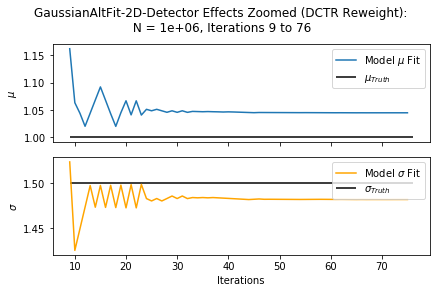

In [34]:
# Zoom into later iterations (finer fit)

fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex= True,  constrained_layout=True)
fig.suptitle("GaussianAltFit-2D-Detector Effects Zoomed (DCTR Reweight):\n N = {:.0e}, Iterations {:.0f} to {:.0f}".format(N,index_refine[1], len(fit_vals)))
axs[0].plot(np.arange(index_refine[1], len(fit_vals[:,0])), fit_vals[index_refine[1]:,0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], index_refine[1], len(fit_vals), label = '$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(np.arange(index_refine[1], len(fit_vals[:,1])), fit_vals[index_refine[1]:,1], label='Model $\sigma$ Fit', color = 'orange')
axs[1].hlines(theta1_param[1], index_refine[1], len(fit_vals), label = '$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
plt.savefig("GaussianAltFit-2D-Detector Effects Zoomed (DCTR Reweight):\n N = {:.0e}, Iterations {:.0f} to {:.0f}.png".format(N,index_refine[1], len(fit_vals)))
plt.show()

#### Compare Fitting between DCTR Reweighting and Analytical Reweighting

In [35]:
reweight_analytically = True

In [36]:
print_weights = LambdaCallback(on_epoch_end=lambda batch,
                               logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = [0., 1.]

fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(monitor='loss',
                              patience = 3,
                              restore_best_weights=True)

In [40]:
myinputs_fit = Input(shape=(1,))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=(2,),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False
index_refine = np.array([0])
batch_size = 2*N
lr_initial = 5e-1 #smaller learning rate yields better precision
iterations = 75 #but requires more epochs to train
optimizer = keras.optimizers.Adam(lr=lr_initial)

def my_loss_wrapper_fit(mysign = 1):
    theta = 0. #starting value
    #Getting theta_prime:
    
    def my_loss(y_true,y_pred):
        #Getting theta_prime:
        if train_theta == False:
            theta_prime = model_fit.layers[-1].get_weights()[0] #when not training theta, fetch as np array
            y_true = tf.gather(y_true, np.arange(1000)) 
        else:
            theta_prime = model_fit.trainable_weights[-1] #when trainingn theta, fetch as tf.Variable
            y_true = tf.gather(y_true, np.arange(batch_size)) 
        y_labels = tf.gather(y_true, [0], axis = 1) #actual y_true for loss
        x_T = tf.gather(y_true, [1], axis = 1) # sim truth for reweighting
        
        #creating tensor with same length as inputs, with theta_prime in every entry
        concat_input_and_params = K.ones(shape = (x_T.shape[0], 2), dtype=tf.float32)*theta_prime
        data = K.concatenate((x_T, concat_input_and_params), axis=-1)
        if reweight_analytically == False: #NN reweight
            w = reweight(data)
        else: # analytical reweight
            w = analytical_reweight(events = x_T, 
                                    mu1 = theta_prime[0], 
                                    sigma1 = theta_prime[1]) 
        
        # Mean Squared Loss
        t_loss = mysign*(y_labels*(y_labels - y_pred)**2+(w)*(1.-y_labels)*(y_labels - y_pred)**2)
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        """
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_labels)*K.log(y_pred) +w*(1-y_labels)*K.log(1-y_pred))
        """
        
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_3 (Lambda)            (None, 1)                 2         
Total params: 16,899
Trainable params: 16,899
Non-trainable params: 0
_________________________________________________________________


In [41]:
for iteration in range(iterations):    
    print("Iteration: ", iteration )
    for i in range(len(model_fit.layers)-1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass
    
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss=my_loss_wrapper_fit(1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train), y_train, epochs=20, batch_size=1000,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer=optimizer, loss=my_loss_wrapper_fit(-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta), y_train_theta, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test_theta), y_test_theta),verbose=1,callbacks=callbacks)
    
    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10
    
    fit_vals_mu = np.array(fit_vals)[(index_refine[-1]):,0]
    fit_vals_sigma = np.array(fit_vals)[(index_refine[-1]):,1]
    
    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
    extrema_mu = np.concatenate((argrelmin(fit_vals_mu)[0], argrelmax(fit_vals_mu)[0]))
    extrema_mu = extrema_mu[extrema_mu>= iteration - index_refine[-1] -20]
            
    extrema_sigma = np.concatenate((argrelmin(fit_vals_sigma)[0], argrelmax(fit_vals_sigma)[0]))
    extrema_sigma = extrema_sigma[extrema_sigma >= iteration - index_refine[-1] - 20]
    '''
    print("index_refine", index_refine)
    print("extrema_mu", extrema_mu)
    print("extrema_sigma", extrema_sigma)
    '''
    
    if (len(extrema_mu) == 0) or (len(extrema_sigma) == 0): # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema_mu) >= 6) and (len(extrema_sigma) >= 6): #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print("Refining learning rate")
        optimizer.lr = optimizer.lr/10
        
        mean_fit = np.array([[np.mean(fit_vals_mu[len(fit_vals_mu)-4:len(fit_vals_mu)]),
                              np.mean(fit_vals_sigma[len(fit_vals_sigma)-4:len(fit_vals_sigma)])]])

        model_fit.layers[-1].set_weights(mean_fit)
    pass
    pass
    

Iteration:  0
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 19s 19us/step - loss: 0.2164 - acc: 0.3247 - val_loss: 0.2132 - val_acc: 0.3287
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2128 - acc: 0.3293 - val_loss: 0.2129 - val_acc: 0.3292
Epoch 3/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2127 - acc: 0.3295 - val_loss: 0.2129 - val_acc: 0.3292
Epoch 4/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2126 - acc: 0.3295 - val_loss: 0.2130 - val_acc: 0.3292
Epoch 5/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2126 - acc: 0.3295 - val_loss: 0.2129 - val_acc: 0.3292
Epoch 6/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2126 - acc: 0.3295 - val_loss: 0.2130 - val_acc: 0.3292
Epoch 7/20
1000000/1000000 [==============================] - 8s 8us/step - los

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2469 - acc: 0.2753 - val_loss: 0.2465 - val_acc: 0.2760
Epoch 4/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2469 - acc: 0.2765 - val_loss: 0.2465 - val_acc: 0.2762
Epoch 5/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2469 - acc: 0.2776 - val_loss: 0.2465 - val_acc: 0.2735
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 14s 7us/step - loss: -0.2466 - acc: 0.2743
. theta fit =  [1.1717167 1.5346624]
Iteration:  5
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 21s 21us/step - loss: 0.2485 - acc: 0.1950 - val_loss: 0.2482 - val_acc: 0.1731
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2483 - acc: 0.1858 - val_loss: 0.2482 - val_acc: 0.1743
Epoch 3/20
1000000/1000000

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2488 - acc: 0.2216 - val_loss: 0.2486 - val_acc: 0.2524
Epoch 3/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2488 - acc: 0.2306 - val_loss: 0.2486 - val_acc: 0.2433
Epoch 4/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2488 - acc: 0.2286 - val_loss: 0.2487 - val_acc: 0.2440
Epoch 5/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2487 - acc: 0.2318 - val_loss: 0.2486 - val_acc: 0.2236
Epoch 6/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2488 - acc: 0.2242 - val_loss: 0.2486 - val_acc: 0.2027
Epoch 7/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2487 - acc: 0.2309 - val_loss: 0.2486 - val_acc: 0.2175
Epoch 8/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2488 - acc: 0.2265 - val_loss: 0.2486 - val_acc: 0.2200
Training theta
Train on 2000000

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2489 - acc: 0.1881 - val_loss: 0.2488 - val_acc: 0.1881
Epoch 8/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2489 - acc: 0.1920 - val_loss: 0.2491 - val_acc: 0.2119
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 15s 8us/step - loss: -0.2488 - acc: 0.1887
. theta fit =  [1.0372562 1.4975249]
Iteration:  15
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 22s 22us/step - loss: 0.2490 - acc: 0.1976 - val_loss: 0.2489 - val_acc: 0.1853
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2489 - acc: 0.1938 - val_loss: 0.2489 - val_acc: 0.1852
Epoch 3/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2488 - acc: 0.2041 - val_loss: 0.2488 - val_acc: 0.1780
Epoch 4/20
1000000/100000

. theta fit =  [1.0006119 1.4729421]
Iteration:  21
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 24s 24us/step - loss: 0.2490 - acc: 0.2562 - val_loss: 0.2491 - val_acc: 0.2885
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2490 - acc: 0.2405 - val_loss: 0.2490 - val_acc: 0.2390
Epoch 3/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2490 - acc: 0.2422 - val_loss: 0.2489 - val_acc: 0.2518
Epoch 4/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2490 - acc: 0.2433 - val_loss: 0.2490 - val_acc: 0.2473
Epoch 5/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2490 - acc: 0.2484 - val_loss: 0.2491 - val_acc: 0.2514
Epoch 6/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2490 - acc: 0.2447 - val_loss: 0.2490 - val_acc: 0.2643
Epoch 7/20
1000000/1000000 [=============

1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2385 - val_loss: 0.2492 - val_acc: 0.2636
Epoch 5/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2452 - val_loss: 0.2491 - val_acc: 0.2662
Epoch 6/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2454 - val_loss: 0.2492 - val_acc: 0.2844
Epoch 7/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2490 - acc: 0.2455 - val_loss: 0.2491 - val_acc: 0.2574
Epoch 8/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2494 - val_loss: 0.2490 - val_acc: 0.2109
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 17s 8us/step - loss: -0.2490 - acc: 0.2662
. theta fit =  [1.003415  1.4863212]
Iteration:  28
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
100000

Epoch 7/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2489 - acc: 0.2405 - val_loss: 0.2490 - val_acc: 0.2834
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 16s 8us/step - loss: -0.2489 - acc: 0.2550
. theta fit =  [0.9977426 1.480443 ]
Iteration:  34
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 26s 26us/step - loss: 0.2490 - acc: 0.2524 - val_loss: 0.2490 - val_acc: 0.2461
Epoch 2/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2522 - val_loss: 0.2491 - val_acc: 0.2347
Epoch 3/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2572 - val_loss: 0.2492 - val_acc: 0.2232
Epoch 4/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2428 - val_loss: 0.2489 - val_acc: 0.2539
Epoch 5/

Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 27s 27us/step - loss: 0.2490 - acc: 0.2428 - val_loss: 0.2491 - val_acc: 0.2683
Epoch 2/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2490 - acc: 0.2516 - val_loss: 0.2491 - val_acc: 0.2730
Epoch 3/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2592 - val_loss: 0.2490 - val_acc: 0.2418
Epoch 4/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2566 - val_loss: 0.2490 - val_acc: 0.2507
Epoch 5/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2530 - val_loss: 0.2490 - val_acc: 0.2569
Epoch 6/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2554 - val_loss: 0.2490 - val_acc: 0.2603
Epoch 7/20
1000000/1000000 [==============================] - 10s 10us/step - loss:

1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2466 - val_loss: 0.2490 - val_acc: 0.2490
Epoch 5/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2491 - val_loss: 0.2492 - val_acc: 0.2641
Epoch 6/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2488 - acc: 0.2639 - val_loss: 0.2490 - val_acc: 0.2508
Epoch 7/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2490 - acc: 0.2440 - val_loss: 0.2490 - val_acc: 0.2464
Epoch 8/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2581 - val_loss: 0.2490 - val_acc: 0.2431
Epoch 9/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2490 - acc: 0.2415 - val_loss: 0.2490 - val_acc: 0.2469
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 18s 9us/step - loss: -0.2490 - acc:

1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2487 - val_loss: 0.2491 - val_acc: 0.2397
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 18s 9us/step - loss: -0.2492 - acc: 0.2664
. theta fit =  [0.9976563 1.4802766]
Iteration:  53
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 29s 29us/step - loss: 0.2490 - acc: 0.2488 - val_loss: 0.2491 - val_acc: 0.2347
Epoch 2/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2489 - acc: 0.2439 - val_loss: 0.2490 - val_acc: 0.2389
Epoch 3/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2489 - acc: 0.2599 - val_loss: 0.2490 - val_acc: 0.2424
Epoch 4/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2489 - acc: 0.2541 - val_loss: 0.2490 - val_acc: 0.2453
Epoch 5/20
100000

1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2489 - acc: 0.2612 - val_loss: 0.2490 - val_acc: 0.2419
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 20s 10us/step - loss: -0.2489 - acc: 0.2579
. theta fit =  [0.9974732 1.4800944]
Iteration:  60
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 30s 30us/step - loss: 0.2489 - acc: 0.2496 - val_loss: 0.2491 - val_acc: 0.2655
Epoch 2/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2533 - val_loss: 0.2490 - val_acc: 0.2400
Epoch 3/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2499 - val_loss: 0.2491 - val_acc: 0.2710
Epoch 4/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2489 - acc: 0.2663 - val_loss: 0.2490 - val_acc: 0.2493
Training theta
T

1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2489 - acc: 0.2643 - val_loss: 0.2490 - val_acc: 0.2451
Epoch 10/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2489 - acc: 0.2438 - val_loss: 0.2489 - val_acc: 0.2697
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 19s 9us/step - loss: -0.2490 - acc: 0.2577
. theta fit =  [0.9975034 1.4801247]
Iteration:  67
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 31s 31us/step - loss: 0.2490 - acc: 0.2627 - val_loss: 0.2491 - val_acc: 0.2573
Epoch 2/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2489 - acc: 0.2623 - val_loss: 0.2490 - val_acc: 0.2542
Epoch 3/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2489 - acc: 0.2470 - val_loss: 0.2491 - val_acc: 0.2428
Epoch 4/20
10000

1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2685 - val_loss: 0.2490 - val_acc: 0.2805
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 21s 11us/step - loss: -0.2492 - acc: 0.2487
. theta fit =  [0.9974989 1.4801124]
Iteration:  74
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 32s 32us/step - loss: 0.2490 - acc: 0.2574 - val_loss: 0.2490 - val_acc: 0.2531
Epoch 2/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2489 - acc: 0.2582 - val_loss: 0.2490 - val_acc: 0.2570
Epoch 3/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2489 - acc: 0.2573 - val_loss: 0.2490 - val_acc: 0.2575
Epoch 4/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2489 - acc: 0.2625 - val_loss: 0.2490 - val_acc: 0.2499
Epoch 5/20
10000

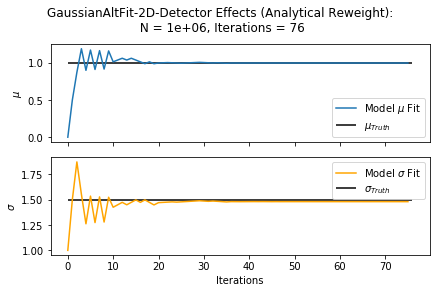

In [42]:
fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex= True,  constrained_layout=True)
fig.suptitle("GaussianAltFit-2D-Detector Effects (Analytical Reweight):\n N = {:.0e}, Iterations = {:.0f}".format(N, len(fit_vals)))
axs[0].plot(fit_vals[:,0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], 0, len(fit_vals), label = '$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(fit_vals[:,1], label='Model $\sigma$ Fit', color ='orange')
axs[1].hlines(theta1_param[1], 0, len(fit_vals), label = '$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
plt.savefig("GaussianAltFit-2D-Detector Effects (Analytical Reweight):\n N = {:.0e}, Iterations = {:.0f}.png".format(N, len(fit_vals)))
plt.show()



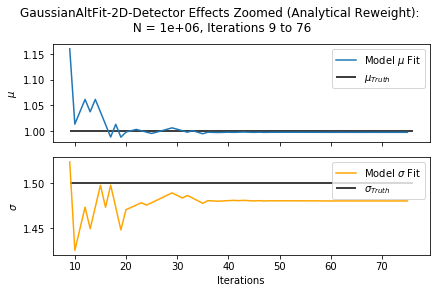

In [43]:
# Zoom into later iterations (finer fit)

fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex= True,  constrained_layout=True)
fig.suptitle("GaussianAltFit-2D-Detector Effects Zoomed (Analytical Reweight):\n N = {:.0e}, Iterations {:.0f} to {:.0f}".format(N,index_refine[1], len(fit_vals)))
axs[0].plot(np.arange(index_refine[1], len(fit_vals[:,0])), fit_vals[index_refine[1]:,0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], index_refine[1], len(fit_vals), label = '$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(np.arange(index_refine[1], len(fit_vals[:,1])), fit_vals[index_refine[1]:,1], label='Model $\sigma$ Fit', color = 'orange')
axs[1].hlines(theta1_param[1], index_refine[1], len(fit_vals), label = '$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
plt.savefig("GaussianAltFit-2D-Detector Effects Zoomed (Analytical Reweight):\n N = {:.0e}, Iterations {:.0f} to {:.0f}.png".format(N,index_refine[1], len(fit_vals)))
plt.show()